In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from collections import Counter
import re
import nltk
#import pymorphy2
from ast import literal_eval
import gensim

## Давайте посмотрим на наши данные


In [3]:
users = pd.read_csv("/content/drive/MyDrive/MTS_summer_school/users.csv")
users.head()

,user_id,age,sex
0,0,45_54,1.0
1,1,25_34,0.0
2,2,45_54,0.0
3,3,65_inf,0.0
4,4,18_24,0.0


In [4]:
items = pd.read_csv("/content/drive/MyDrive/MTS_summer_school/items.csv")
items.head()

,id,title,genres,authors,year
0,248031,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,256084,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,134166,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,281311,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,213473,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


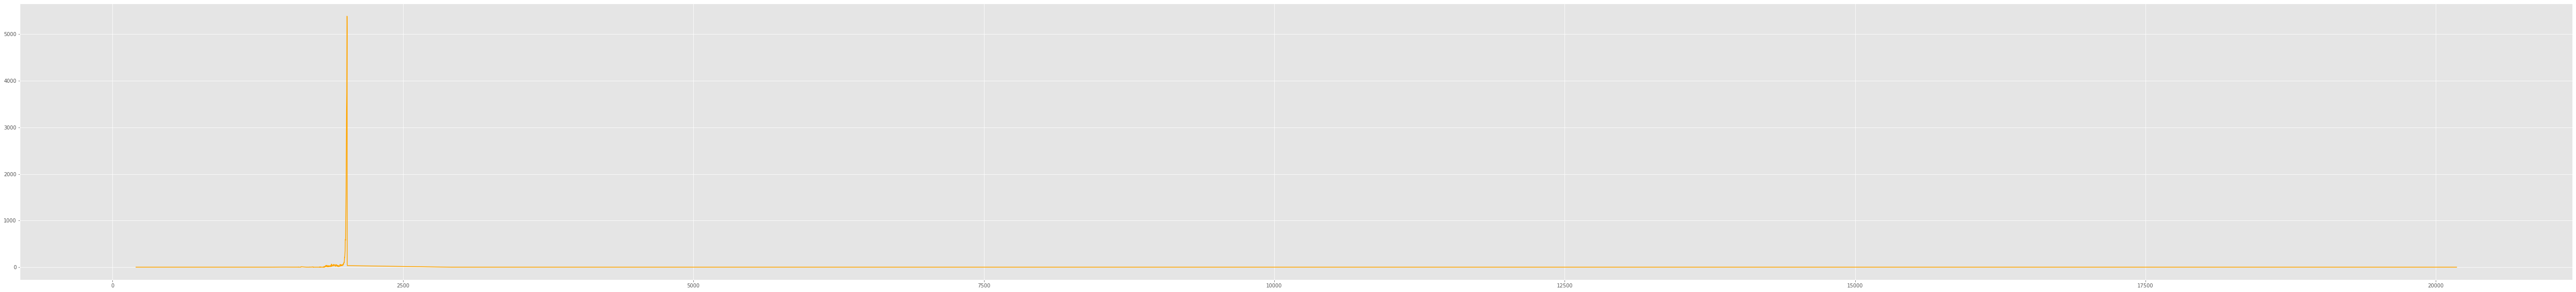

In [5]:
year_gist = {}
bad_set = set()
for i in items['year']:
    try:
        cur_year = int(i)
        if cur_year in year_gist:
            year_gist[cur_year] += 1
        else:
            year_gist[cur_year] = 1
    except:
        bad_set.add(i)
# print(bad_set) # Ну и помойка здесь хранится... Например, '1926, 1927,1934, 1941' - отличный год выпуска книжки!
year_gist_sort = sorted(year_gist.items(), key=lambda x: x[0])

A, B = [], []
for i in year_gist_sort:
    A.append(i[0])
    B.append(i[1])

fig = plt.figure(figsize=(90, 10))
ax = fig.add_subplot(111)
ax.plot(A, B, color='orange')
plt.show()

### Ох уж эти выбросы... Давайте их выкидывать

[(2018, 5382), (2019, 5053), (2017, 4738), (2016, 3734), (2015, 3554), (2014, 3353), (2013, 2958), (2012, 2456), (2011, 1917), (2010, 1563), (2009, 1402), (2008, 1128), (2007, 842), (2006, 691), (2004, 598), (2005, 577), (2003, 535), (2002, 346), (2001, 329), (2000, 284), (1999, 226), (1997, 216), (1998, 205), (1996, 173), (1995, 122), (1993, 107), (2020, 103), (1994, 100), (1991, 96), (1992, 95), (1990, 86), (1987, 74), (1989, 69), (1988, 68), (1885, 67), (1985, 67), (1903, 61), (1959, 61), (1984, 59), (1962, 58), (1925, 56), (1922, 55), (1975, 55), (1912, 53), (1970, 52), (1910, 51), (1908, 51), (1986, 51), (1891, 50), (1983, 50), (1886, 49), (1923, 49), (1909, 49), (1927, 48), (1980, 48), (1924, 47), (1884, 46), (1926, 46), (1979, 45), (1961, 45), (1936, 44), (1911, 44), (1978, 44), (1900, 43), (1907, 43), (1913, 43), (1972, 43), (1906, 42), (1878, 42), (1904, 42), (1897, 42), (1960, 42), (1898, 41), (1905, 41), (1930, 41), (1963, 41), (1977, 41), (1971, 41), (1847, 40), (1841, 40),

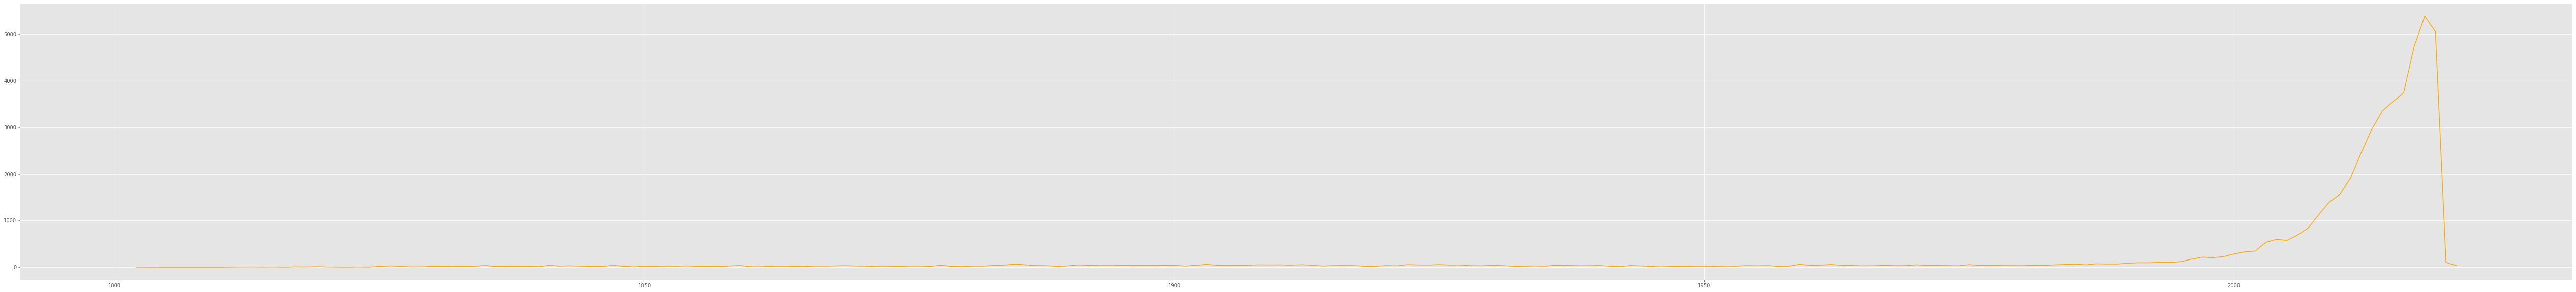

In [6]:
A, B, C = [], [], []
year_gist_sort_by_count = sorted(year_gist.items(), key=lambda x: x[1], reverse=True)
print(year_gist_sort_by_count)
for i in year_gist_sort:
    if 1800 < i[0] < 2022:
        A.append(i[0])
        B.append(i[1])
        C.append(i[1])

B.sort(reverse=True)
print(B)
fig = plt.figure(figsize=(90, 10))
ax = fig.add_subplot(111)
ax.plot(A, C, color='orange')
plt.show()

### Ну давайте просто обрубим этот тяжёлый конец :)

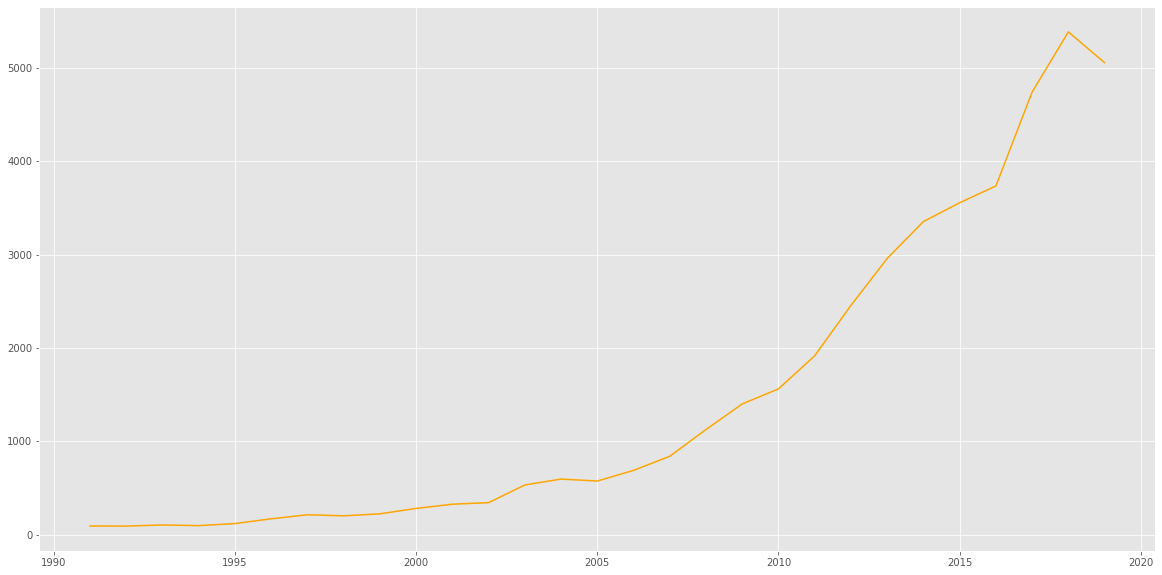

In [7]:
A, B, C = [], [], []
year_gist_sort_by_count = sorted(year_gist.items(), key=lambda x: x[1], reverse=True)
for i in year_gist_sort:
    if 1990 < i[0] < 2020:
        A.append(i[0])
        B.append(i[1])
        C.append(i[1])
        

B.sort(reverse=True)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(A, C, color='orange')
plt.show()

### Тогда давайте создадим новую табличку с данными, где будет только id и год в рамках 1990 - 2020

In [8]:
my_year, my_id = [], []
set_good_id = set()
for i in items[['id', 'year']].values:
    try:
        cur_year = int(i[1])
        if 1990 < cur_year < 2020:
            my_id.append(int(i[0]))
            my_year.append(cur_year)
            set_good_id.add(int(i[0]))
    except:
        pass

my_items = pd.DataFrame({'id': np.array(my_id), 'year': np.array(my_year)})
my_items.head(12)

,id,year
0,389882,2016
1,50848,2014
2,9518,2015
3,319625,2001
4,145272,2001
5,83321,2008
6,270591,2009
7,175563,2002
8,81100,2007
9,341268,2007


In [9]:
interactions = pd.read_csv("/content/drive/MyDrive/MTS_summer_school/interactions.csv")
interactions.head()

,user_id,item_id,progress,rating,start_date
0,90133,82910,100,NaN,2018-01-01
1,159130,331068,70,NaN,2018-01-01
2,80061,26540,69,4.0,2018-01-01
3,12811,301895,16,NaN,2018-01-01
4,5778,127872,100,NaN,2018-01-01


In [10]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562617 entries, 0 to 1562616
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1562617 non-null  int64  
 1   item_id     1562617 non-null  int64  
 2   progress    1562617 non-null  int64  
 3   rating      323571 non-null   float64
 4   start_date  1562617 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 59.6+ MB


### Замечаем два лютых выброса. Оно и логично, конечно, но скорее всего их придётся выбросить или крутить для них коэффициенты. 


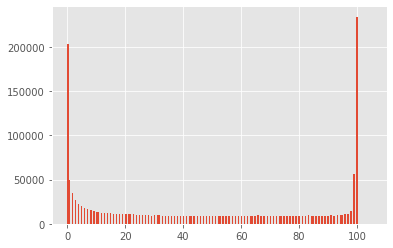

In [11]:
interactions.progress.hist(bins=200);

## Холодный старт

### В первую очередь поймём, что в рекомендательных системах есть проблема холодного старта. Что если пользователь новый? Что же ему посоветовать?


### Моя идея - для каждого типа людей выводить свой топ. Например, если ты девушка 27 лет, то тебе рекомендовать топовые книги среди девушек от 25 до 34.



In [16]:
class Top():
    def __init__(self, users, interactions, items):
        # my_big_array = []
        self.my_big_dict = {}
        self.my_big_rating_dict = {}
        self.my_final_rating_dict = {}
        self.max_len = 0
        self.answer = {}
        self.my_big_users_dict = {}
        self.my_global = {}

        for i in users[["user_id", "age", "sex"]].values:
            if str(i[1]) != "nan" and str(i[2]) != "nan":
                self.my_big_users_dict[i[0]] = str(i[1]) + str(i[2])
                self.my_big_rating_dict[str(i[1]) + str(i[2])] = {}
            
        for i in tqdm(interactions[["user_id", "item_id", "progress", "rating"]].values):  # Прекрасно понимаю, что не супер оптимальный алгоритм, но исправлю как-нибудь потом :) 
            self.max_len += 1

            if i[0] in self.my_big_users_dict and i[1] in set_good_id:
                my_current_agesex = self.my_big_users_dict[i[0]]
                if i[1] in self.my_big_rating_dict[my_current_agesex]:
                    if str(i[3]) != "nan" and str(i[2]) != "nan":
                        if int(i[2]) > 5:
                            self.my_big_rating_dict[my_current_agesex][i[1]].append(int(i[2]) * int(i[3]))
                            if i[1] in self.my_global:
                                self.my_global[i[1]].append(int(i[2]) * int(i[3]))
                            else:
                                self.my_global[i[1]] = []
                                self.my_global[i[1]].append(int(i[2]) * int(i[3]))
                    elif str(i[2]) != "nan":
                        if int(i[2]) > 5:
                            self.my_big_rating_dict[my_current_agesex][i[1]].append(int(i[2]) * 4)
                            if i[1] in self.my_global:
                                self.my_global[i[1]].append(int(i[2]) * 4)
                            else:
                                self.my_global[i[1]] = []
                                self.my_global[i[1]].append(int(i[2]) * 4)
                else:
                    if str(i[3]) != "nan" and str(i[2]) != "nan":
                        if int(i[2]) > 5:
                            self.my_big_rating_dict[my_current_agesex][i[1]] = [int(i[2]) * int(i[3])]
                            if i[1] in self.my_global:
                                self.my_global[i[1]].append(int(i[2]) * int(i[3]))
                            else:
                                self.my_global[i[1]] = []
                                self.my_global[i[1]].append(int(i[2]) * int(i[3]))
                            
                    elif str(i[2]) != "nan":
                        if int(i[2]) > 5:
                            self.my_big_rating_dict[my_current_agesex][i[1]] = [int(i[2]) * 4]
                            if i[1] in self.my_global:
                                self.my_global[i[1]].append(int(i[2]) * 4)
                            else:
                                self.my_global[i[1]] = []
                                self.my_global[i[1]].append(int(i[2]) * 4)
                
        for i in self.my_big_rating_dict.items():
            self.my_final_rating_dict[i[0]] = {}
            for j in i[1]:
                self.my_final_rating_dict[i[0]][j] = (sum(self.my_big_rating_dict[i[0]][j]) / self.max_len) # (sum(self.my_big_rating_dict[i][j]) / len(self.my_big_rating_dict[i][j])) * (len(self.my_big_rating_dict[i][j]) / self.max_len)
            #print(self.my_final_rating_dict[i[0]].items())
            d = sorted(self.my_final_rating_dict[i[0]].items(), key=lambda x: x[1], reverse=True)
            #print(d)
            k = 0
            for j in d:
                if k == 0:
                    self.answer[i[0]] = [int(j[0])]
                else:
                    self.answer[i[0]].append(int(j[0]))
                k += 1
                if k == 10:
                    break
        gg = {}
        for i in self.my_global.items():
            gg[i[0]] = (sum(self.my_global[i[0]]) / self.max_len)
        
        d = sorted(gg.items(), key=lambda x: x[1], reverse=True)
        #print(d)
        k = 0
        for j in d:
            if k == 0:
                self.answer[0] = [int(j[0])]
            else:
                self.answer[0].append(int(j[0]))
            k += 1
            if k == 10:
                break
        # print(self.answer)
    def give_me_some_info(self, id):
        if id not in self.my_big_users_dict:
            return 0
        else:
            return self.my_big_users_dict[id]

    def top_books(self, some_info):
        return self.answer[some_info]

In [17]:
T = Top(users, interactions, items)


100%|██████████| 1562617/1562617 [00:10<00:00, 148539.89it/s]


## Создаём табличку для отправки на Kaggle

In [18]:
Result_table = pd.read_csv("/content/drive/MyDrive/MTS_summer_school/sample_submission.csv")

In [20]:


result = []
for i in Result_table[['Id']].values:
    if i != 'Id':
        result.append(' '.join(map(str, T.top_books(T.give_me_some_info(int(i))))))
#print(result)
ser = pd.Series(result)
#print(ser)
Result_table['Predicted'] = ser
Result_table[["Id", "Predicted"]].to_csv("FINAL2.csv", index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
